# Prediction - Time to Sale

In this notebook Machine Learning techniques will be used in conjunction with the data generated by the program marketplace_predictions.py to examine whether we can predict how long (i.e. how many market iterations) it takes a successful seller to have their order purchased. This is the final part of the prediction task. This notebook is structured as follows

    1. Comparison of Prediction Algorithms
    2. Plotting how the algorithms compare?
    3. Confusion Matrix
    4. Summary

# 1. Comparison of Prediction Algorithms

We will compare the effectiveness of the Linear Regression, Random Forest and K-Nearest Neighbours algorithms in predicting the time to sale in our data set. Below are two functions, similar to those used in the last notebook, which grab the data, do some wrangling and create some new features like z-scores, and compute the accuracy of the predictions. Note that here we've used the Regressor versions of the algorithms as opposed to the Classification versions used in the previous chapter. This was done purely for demonstrative purposes - the resulting regression predictions can be mapped directly to the discrete classes (i.e. Days taken until sale) simply by rounding.

In [17]:
from sklearn.linear_model import LinearRegression ; from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import KFold ; from sklearn.ensemble import RandomForestRegressor
import pandas as pd ; import numpy as np ; from sklearn.svm import SVC ; 
from sklearn.metrics import accuracy_score; from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold,train_test_split,cross_val_score


def get_df(param_set, run):
    """
    Returns a wrangled dataframe for the input parameter set and run number
    """
    param_set = str(param_set) ;    run = str(run)
    sold = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_sold.csv')
    ### Cast Day Tracker to list, trim data points within 'cutoff' days of simulation start/ends
    sold['Day Tracker'] = sold['Day Tracker'].apply(lambda x: x.split(','));
    sold = sold[sold['Day Advertised'] >=  8]; sold = sold[sold['Day Advertised'] <=  290]
    ## Create rates for each day for insertion into sold df
    rates = pd.read_csv('../exploration/data/'+param_set+'_set_run_'+str(run)+'_rates.csv')
    rate_dic = rates.to_dict()#['USD to EUR rate','USD sales','EUR sales']
    ### Get length of day tracker, save as new column - This is days spent in the market
    sold['Lens'] = sold['Day Tracker'].apply(lambda x : len(x));

    # Create a column for the interbank rate for the day advertised
    sold['Interbank'] = sold.apply(lambda row: rate_dic['USD to EUR rate'][row['Day Advertised']]\
                                   if(row['Currency']=='USD')\
                                   else 1.0/rate_dic['USD to EUR rate'][row['Day Advertised']],axis=1)

    # Now do the z-scores
    sd_denom = 100.0 # standard deviation denominator, set in marketplace.py default value = 100 yields true SD = RATE/100
    sold.drop(['ID','Current Amount','Sale Tracker','Day Tracker',],inplace=True,axis=1);
    sold['z-score'] = sold.apply(lambda row: (row['Rate Offered']-row['Interbank'] )/ (row['Interbank']/sd_denom ),axis=1)

    ## Rescale Features
    sold['Currency'] = sold.apply(lambda row: 0 if(row['Currency']=='EUR') else 1,axis=1)
    sold['Initial Amount'] = sold.apply(lambda row: (row['Initial Amount'])/np.max(sold['Initial Amount']),axis=1)
    sold['EUR sales'] =  sold.apply(lambda row: np.log10(rate_dic['EUR sales'][row['Day Advertised']]),axis=1)
    sold['USD sales'] =  sold.apply(lambda row: np.log10(rate_dic['USD sales'][row['Day Advertised']]),axis=1)
    sold['Day Advertised'] = sold.apply(lambda row: (row['Day Advertised'])/np.max(sold['Day Advertised']),axis=1)

    return sold

def get_accuracy(df,alg,predictors):
    """
    Returns the accuracy of algorithm alg in predicting the length of time it takes a sale
    for sellers in dataframe df, using predictors in the input list predictors.
    """
    X = df.reset_index()[predictors]
    Y = df.reset_index()["Lens"]
  
  #  return cross_val_score(alg, X, Y, cv = KFold(len(X), n_folds=10,
  #                                          shuffle=True, random_state=4)).mean()
    
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2,
                                                    random_state=0)
    # Train the model, and evaluate it
    alg.fit(train_X, train_Y)
    y_pred = alg.predict(test_X)
    return accuracy_score(test_Y, np.round(y_pred))
    

Now let's use these to compare the different prediction methods. We will iterate through all the parameter sets and the three chosen algorithms and output this into a matrix called model_eval, which we can then plot and study.

## WARNING: This takes ~15 mins to run!

In [11]:
algos = [LinearRegression(),\
        RandomForestRegressor(n_estimators=15),\
        KNeighborsRegressor(n_neighbors=15)]

predictors = ['Currency', 'Initial Amount', 'Rate Offered',\
                  'z-score',\
                'Interbank',
                  #'Day Advertised',\
      #            'EUR sales','USD sales'\
                ]

cols = ['LinReg','RFR','KNN',]

param_sets = range(1,8)
runs = range(0,5)

# We'll use this dataframe to make some plots to compare the algos
model_eval =  pd.DataFrame(index=None, columns=cols).fillna(0)

### Iterate through the algorithms and their names
for alg_class, col in zip(algos,cols):
        print 'Algo = ', col
        for param_set in param_sets:
            avg = [0]*len(runs)
            for run in runs:
                print 'Evaluating run ', run, ' of pset ', param_set
                df = get_df(param_set,run)
                alg = alg_class
                acc = get_accuracy(df, alg, predictors)
                avg[run] = acc
            mean = np.mean(np.array(avg))
            model_eval.ix[str(param_set),col] = mean
            print mean #, avg
print model_eval

model_eval.to_csv('time_to_sale_prediction_table.csv')


Algo =  LinReg
Evaluating run  0  of pset  1
Evaluating run  1  of pset  1
Evaluating run  2  of pset  1
Evaluating run  3  of pset  1
Evaluating run  4  of pset  1
0.995337820397
Evaluating run  0  of pset  2
Evaluating run  1  of pset  2
Evaluating run  2  of pset  2
Evaluating run  3  of pset  2
Evaluating run  4  of pset  2
0.494866033605
Evaluating run  0  of pset  3
Evaluating run  1  of pset  3
Evaluating run  2  of pset  3
Evaluating run  3  of pset  3
Evaluating run  4  of pset  3
0.270962240512
Evaluating run  0  of pset  4
Evaluating run  1  of pset  4
Evaluating run  2  of pset  4
Evaluating run  3  of pset  4
Evaluating run  4  of pset  4
0.988196281741
Evaluating run  0  of pset  5
Evaluating run  1  of pset  5
Evaluating run  2  of pset  5
Evaluating run  3  of pset  5
Evaluating run  4  of pset  5
0.434286987385
Evaluating run  0  of pset  6
Evaluating run  1  of pset  6
Evaluating run  2  of pset  6
Evaluating run  3  of pset  6
Evaluating run  4  of pset  6
0.25273363

# 2. Plotting how the algorithms compare?
 
Let's write out model_eval again:

In [13]:
print model_eval

      LinReg        RFR        KNN
1  0.9953378  0.9947198  0.9953378
2   0.494866  0.8024029  0.7223946
3  0.2709622   0.915277  0.4233495
4  0.9881963  0.9812875   0.984872
5   0.434287  0.8609714  0.7750891
6  0.2527336  0.9275704  0.4374234
7  0.2516422  0.9233955  0.4136163


We can make a plot of this matrix like we did in the deal_or_no_deal notebook

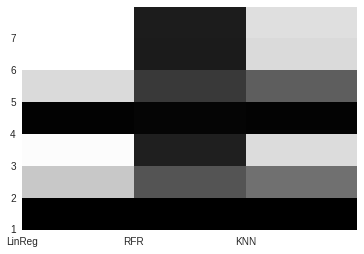

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
plt.pcolor(model_eval)
plt.yticks(np.arange(0.0, len(model_eval.index), 1), model_eval.index)
plt.xticks(np.arange(0.0, len(model_eval.columns), 1), model_eval.columns)
plt.show()

And a bar chart

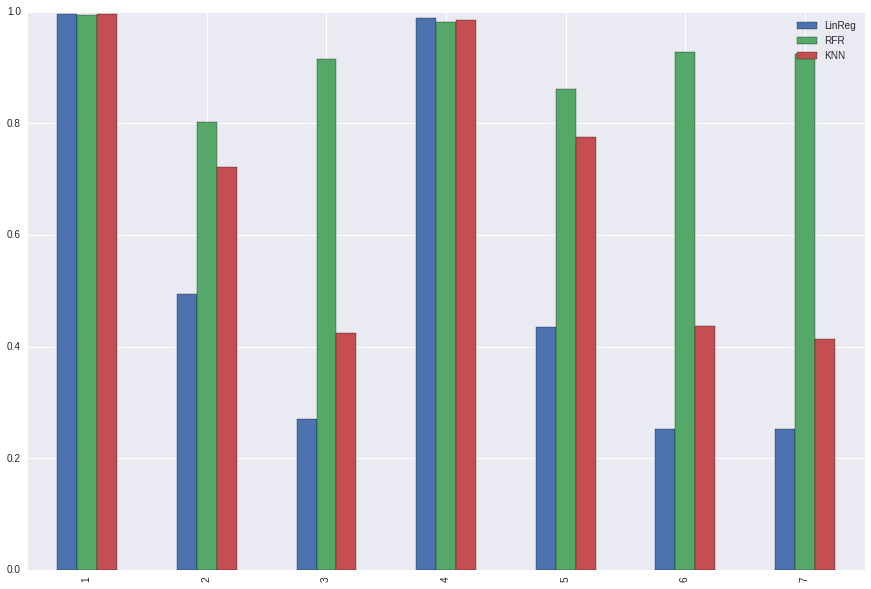

In [15]:
model_eval.plot(kind='bar',ylim=([0.0,1]),figsize=(15,10))

Recall our parameter sets defined in data_exploration_2.ipynb - Parameter sets 1 and 4 are for the 'constant' exchange rate, our most simplistic model. All three algorithms score particularly well here. Sets 2 and 5 were for the sine model, and we can see that now the mode has been made a bit more complicated the algorithms perform worse, linear regression faring particularly poorly. Parameter sets 3, 6 and 7 correspond to the GBM model and have increasingly complicated behvaiour with 7 being the most complex: irregular number of buyers/sellers on every iteration; and big differences between the trader characteristics in each currency (mean and SD of amounts chosen).

# 3. Confusion Matrix

From the above plots we can see that Random Forest is the far superior prediction algorithm. But just how well does this algorithm classify? We know from the data_exploration_2 notebook that the majority of sales occur on the first day, so we need to check whether this algorithm is just really good at predicting Day 1 sellers which could be biasing the results. We can use a confusion matrix again to see how well our prediction system scores across all the possible classifications.

The default for the code below uses data from a single run of the seventh parameter set, which is our most complicated model. The Random Forest algorithm is used and the confusion matrix output below.

In [22]:
import matplotlib.pylab as plt
from sklearn.cross_validation import KFold,train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd ; import numpy as np
from sklearn.metrics import confusion_matrix
%matplotlib inline  
    
param_set = 7
run = 0

df  = get_df(param_set,run)
predictors = ['Currency', 'Initial Amount', 'Rate Offered',\
                  'z-score',\
                'Interbank',
              #'Day Advertised',\
#                  'EUR sales','USD sales'\
                ]

# Initialise dataframe and target set Y
X = df.reset_index()[predictors]
Y = df.reset_index()["Lens"]

# Let's just do a manual split here, no need for kfolds
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2)

# Train the model, and evaluate it
alg = RandomForestRegressor(n_estimators=20,
                                max_features = 'auto',
                                max_depth = 20,
                                min_samples_leaf = 3)
alg.fit(train_X, train_Y)
y_pred = alg.predict(test_X)
print accuracy_score(test_Y, np.round(y_pred))
# Calculate confusion matrix
cm = pd.crosstab(test_Y, np.round(y_pred), rownames=['Actual'], colnames=['Predicted'], margins=True)
cm = cm  # cm.sum(axis=1)    # < Uncomment for normalisation
print cm
    

0.87114967462
Predicted   1.0   2.0  3.0  4.0  5.0  6.0  7.0  8.0   All
Actual                                                   
1          5368   311   39   10   12    4    5    0  5749
2           106   946   35   10    0    0    0    0  1097
3             8    90  455   25    6    0    1    1   586
4             3    17   65  340   22    2    0    0   449
5             1     6   14   66  345   19    0    0   451
6             2     7    8    7   51  233   11    0   319
7             0     2    5   10    9   74  223    5   328
8             4     3    9    7   12   29   55  122   241
All        5492  1382  630  475  457  361  295  128  9220


As the output shows, we scored fairly good accuracy and our algorithm classifies across all the different days fairly well, with very little mis-classification of the data. By using a large number of estimators (N=50) in the Random Forest algorithm we make the method more robust to overfitting.

# 4. Summary

The results of this notebook are that Random Forest is the best predictive algorithm that we tried, scoring around 87% accuracy for the most complicated market behaviour with very little misclassification. While this is initially quite promising, we must remember that the strict mathematical rules of our initial marketplace results in highly idealised behaviours of the buyers and sellers in the market, so the same predictive algorithm may not perform as well in a real-world scenario where effects such as changing migration patterns, recessions and other phenomena will come into play, especially when trying to model the market over long time periods.

This concludes the prediction part of this project. A summary of the whole project is presented in the file summary.txt located in the top project directory.